In [1]:
import pathlib
import pandas as pd
import json
import numpy as np
from itertools import combinations
from pymatgen.core import Structure
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def volume_to_lattice_constant(volume, structure_type):
    if structure_type in ['X2O', 'XO', 'XO2']:
        return (4 * volume) ** (1/3)
    elif structure_type in ['X2O5', 'XO3', 'X2O3']:
        return (1 * volume) ** (1/3)
    else:
        raise ValueError('Unknown structure type')
        

In [3]:
data_path = pathlib.Path('/Users/treents/project/aiida-cwf/data')

In [4]:
code_filenames = {
    'PBE': {
        'FLEUR': 'results-oxides-actinides-v01-pbe-fleur_centralVolume.json', 
        'WIEN2k': 'oxides_pbe_prec3.json',
        'SIRIUS-CP2k': 'CentralVolume-oxides-PBE-v1-cp2k.json'
        },
    'PBEsol': {
        'FLEUR': 'results-oxides-PBEsol-fleur_centralVolume.json', 
        'WIEN2k': 'results-oxides-PBEsol-WIEN2k.json', 
        'SIRIUS-CP2k': 'CentralVolume-oxides-PBEsol-cp2k.json'
        },
    'LDA': {
        'FLEUR': 'results-oxides-LDA-PW92-fleur_centralVolume.json',
        'WIEN2k': 'results-oxides-lda-v1-wien2k.json', 
        'SIRIUS-CP2k': 'CentralVolume-oxides-LDA-cp2k.json'
        },
}

with open('/Users/treents/project/aiida-cwf/git/acwf-verification-scripts/0-preliminary-do-not-run/oxides/verification-PBE-v1_alat_and_vol.json', 'r') as f:
    pbe_old = json.load(f)

In [5]:
min_volumes_codes = {}
for xc in code_filenames:
    min_volumes_codes[xc] = {}
    for code in code_filenames[xc]:
        with open(data_path / code.lower() / 'for central volumes' / code_filenames[xc][code]) as f:
            data = json.load(f)
            min_volumes_codes[xc][code] = data['BM_fit_data']

In [6]:
lattice_constants = {}
min_volumes = {}

for xc in code_filenames:
    lattice_constants[xc] = {}
    min_volumes[xc] = {}

    configurations = list(min_volumes_codes[xc]['WIEN2k'].keys())

    for config in configurations:
        el, crystal_system = config.split('-')
        # crystal_system = crystal_system.split('-')[1]
        for code in code_filenames[xc]:
            # print(code)
            if config not in min_volumes_codes[xc][code]:
                continue
            elif min_volumes_codes[xc][code][config] is None:
                # lattice_constants[xc].setdefault(crystal_system, {}).setdefault(el, []).append(
                #     volume_to_lattice_constant(volume, crystal_system)
                #     )
                # min_volumes[xc].setdefault(crystal_system, {}).setdefault(el, []).append(volume)
                print(f"Skipping {xc} {code} {config}")
                continue

            volume = min_volumes_codes[xc][code][config]['min_volume']
            if config in ['O-XO', 'O-X2O5'] and code == 'WIEN2k':
                print(code, config)
                volume = volume / 2
            # lattice_constants[xc].setdefault(crystal_system, {}).setdefault(el, []).append(volume_to_lattice_constant(volume, crystal_system))
            min_volumes[xc].setdefault(crystal_system, {}).setdefault(el, []).append(volume)

WIEN2k O-X2O5
WIEN2k O-XO
WIEN2k O-X2O5
WIEN2k O-XO


PBE ('FLEUR', 'SIRIUS-CP2k') 0.0011128983383570223 0.12617309686593278
PBE ('FLEUR', 'WIEN2k') 8.208098408400648e-05 0.08433582438822117
PBE ('SIRIUS-CP2k', 'WIEN2k') 6.504107270612651e-05 0.12179206437810058
PBEsol ('FLEUR', 'SIRIUS-CP2k') 9.292870726378125e-05 1.299014485497165
PBEsol ('FLEUR', 'WIEN2k') 5.14736210023169e-06 99.97819707229011
PBEsol ('SIRIUS-CP2k', 'WIEN2k') 8.230784249504414e-06 100.03535816372484
LDA ('FLEUR', 'SIRIUS-CP2k') 7.700461726922426e-05 0.9945991280211609
LDA ('FLEUR', 'WIEN2k') 5.220469405254038e-05 100.18093351622505
LDA ('SIRIUS-CP2k', 'WIEN2k') 0.000276482040514568 100.3169115282546


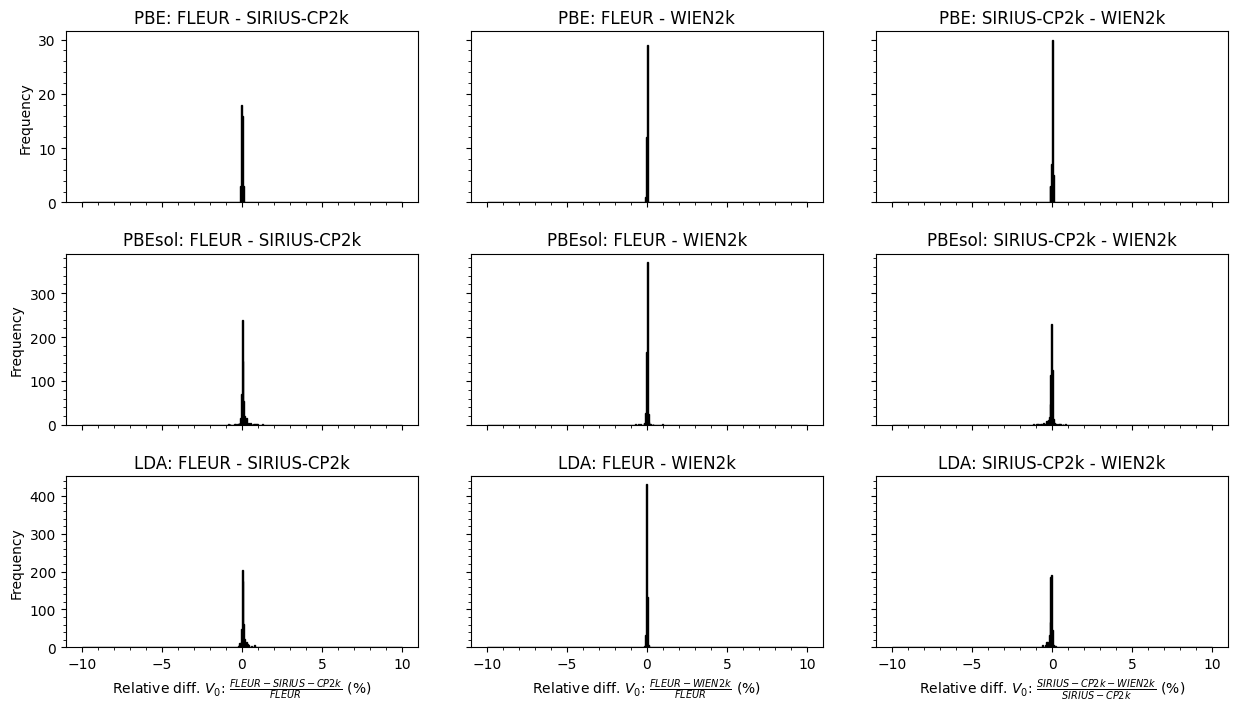

In [7]:
fig, ax = plt.subplots(3, 3, figsize=(15, 8), sharex=True, sharey='row')
plt.subplots_adjust(hspace=0.3, wspace=0.15)
for i, xc in enumerate(lattice_constants):
    for j, code_pair in enumerate([('FLEUR', 'SIRIUS-CP2k'), ('FLEUR', 'WIEN2k'), ('SIRIUS-CP2k', 'WIEN2k')]):
        rel_diffs = []
        for config in configurations:
            if config not in min_volumes_codes[xc][code_pair[0]] or config not in min_volumes_codes[xc][code_pair[1]]:
                continue
            elif min_volumes_codes[xc][code_pair[0]][config] is None or min_volumes_codes[xc][code_pair[1]][config] is None:
                print(f"Skipping {xc} {config}")
                continue
            rel_diff = (
                min_volumes_codes[xc][code_pair[0]][config]['min_volume'] - min_volumes_codes[xc][code_pair[1]][config]['min_volume']
            ) / min_volumes_codes[xc][code_pair[0]][config]['min_volume'] * 100
            rel_diffs.append(rel_diff)
        sns.histplot(
            rel_diffs, bins=np.arange(-10, 10, 0.051), alpha=0.5, legend=False, ax=ax[i, j], linewidth=1
        )
        ax[i, j].set_title(f'{xc}: {" - ".join(code_pair)}')
        ax[i, j].set_xlabel(f'Relative diff. $V_0$: $\\frac{{{code_pair[0]} - {code_pair[1]}}}{{{code_pair[0]}}}$ (%)')
        print(xc, code_pair, min(np.abs(rel_diffs)), max(np.abs(rel_diffs)))
        ax[i, j].set_ylabel('Frequency')
        # ax[i, j].set_xlim(-1, 1)
        # ax[i, j].set_ylim(0, 10)
        ax[i, j].minorticks_on()
            


In [8]:
lattice_constants_mean = {}
lattice_constants_std = {}
min_volumes_mean = {}
min_volumes_std = {}

for xc in lattice_constants:
    lattice_constants_mean[xc] = {}
    lattice_constants_std[xc] = {}
    for crystal_system in min_volumes[xc]:
        lattice_constants_mean[xc][crystal_system] = {}
        lattice_constants_std[xc][crystal_system] = {}
        for el in min_volumes[xc][crystal_system]:
            lattice_constants_mean[xc][crystal_system][el] = volume_to_lattice_constant(
                np.mean(min_volumes[xc][crystal_system][el]), crystal_system
                )
            
            # lattice_constants_std[xc][crystal_system][el] = np.std(
            #     lattice_constants[xc][crystal_system][el]
            #     )
            
            min_volumes_mean.setdefault(xc, {}).setdefault(
                crystal_system, {}
                )[el] = np.mean(min_volumes[xc][crystal_system][el])
            min_volumes_std.setdefault(xc, {}).setdefault(
                crystal_system, {}
                )[el] = np.std(min_volumes[xc][crystal_system][el])

In [10]:
pbe_old_vol = {}
pbe_old_alat = {}
for config in pbe_old:
    el, crystal_system = config.split('-')
    pbe_old_vol.setdefault(crystal_system, {})[el] = pbe_old[config]['average_vol_wien2k_fleur']
    pbe_old_alat.setdefault(crystal_system, {})[el] = volume_to_lattice_constant(
        pbe_old[config]['average_vol_wien2k_fleur'], crystal_system
        )

In [13]:
with open('central_volumes_oxides-verification-LDA-v1.json', 'w') as f:
    json.dump(min_volumes_mean['LDA'], f, indent=4)
    
with open('central_volumes_oxides-verification-PBE-actinides-v1.json', 'w') as f:
    json.dump(min_volumes_mean['PBE'], f, indent=4)

with open('central_volumes_oxides-verification-PBEsol-v1.json', 'w') as f:
    json.dump(min_volumes_mean['PBEsol'], f, indent=4)
    
with open('conv_lattice_constants_oxides-verification-LDA-v1.json', 'w') as f:
    json.dump(lattice_constants_mean['LDA'], f, indent=4)

with open('conv_lattice_constants_oxides-verification-PBE-actinides-v1.json', 'w') as f:
    json.dump(lattice_constants_mean['PBE'], f, indent=4)
    
with open('conv_lattice_constants_oxides-verification-PBEsol-v1.json', 'w') as f:
    json.dump(lattice_constants_mean['PBEsol'], f, indent=4)
    
with open('conv_lattice_constants_oxides-verification-PBE-v1.json', 'w') as f:
    json.dump(pbe_old_alat, f, indent=4)

with open('central_volumes_oxides-verification-PBE-v1.json', 'w') as f:
    json.dump(pbe_old_vol, f, indent=4)

In [12]:
# with open('/Users/treents/project/aiida-cwf/git/acwf-verification-scripts/0-preliminary-do-not-run/unaries/lattice_parameters_unaries-verification-LDA-v1.json', 'r') as f:
#     lda_alat = json.load(f)
    
# with open('/Users/treents/project/aiida-cwf/git/acwf-verification-scripts/0-preliminary-do-not-run/unaries/lattice_parameters_unaries-verification-PBE-actinides-v1.json', 'r') as f:
#     pbe_alat = json.load(f)

# with open('/Users/treents/project/aiida-cwf/git/acwf-verification-scripts/0-preliminary-do-not-run/unaries/lattice_parameters_unaries-verification-PBEsol-v1.json', 'r') as f:
#     pbesol_alat = json.load(f)
    
# with open('/Users/treents/project/aiida-cwf/git/acwf-verification-scripts/0-preliminary-do-not-run/unaries/lattice_parameters_unaries-verification-PBE-v1.json', 'r') as f:
#     pbe_1_96 = json.load(f)
#     for k in pbe_1_96:
#         pbe_alat[k].update(pbe_1_96[k])
    
# lattice_constants = {
#     'LDA': lda_alat,
#     'PBE': pbe_alat,
#     'PBEsol': pbesol_alat
# }

In [13]:
from ase.data import chemical_symbols
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

Z_max = 103
Pettifor_max = 103

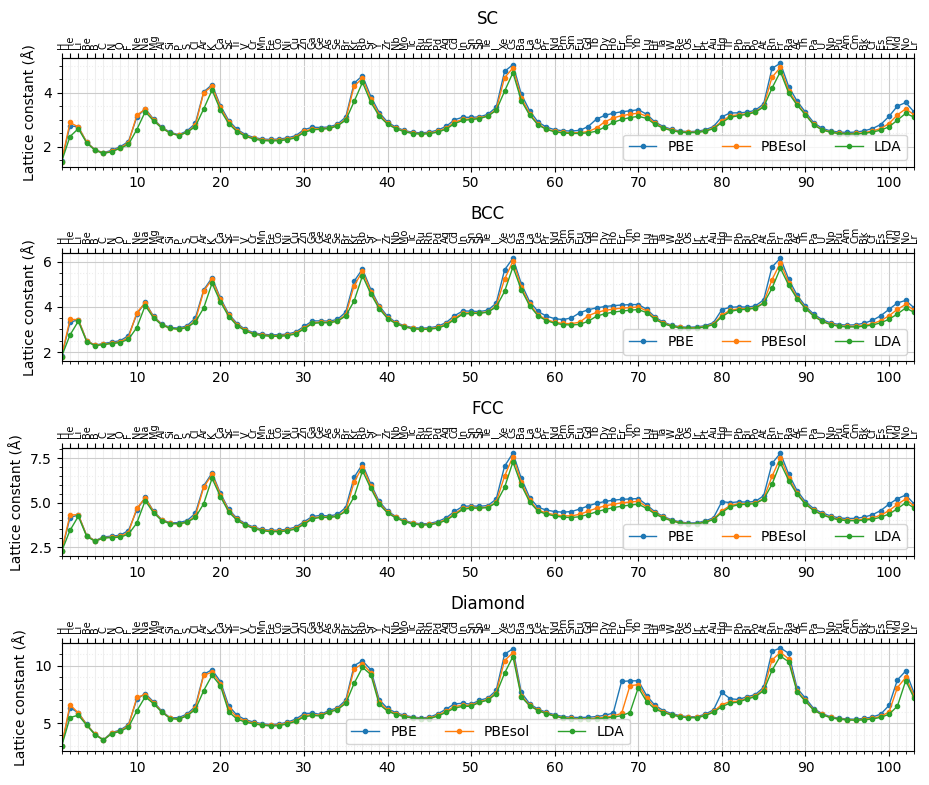

In [14]:
fig, ax = plt.subplots(4, 1, figsize=(11, 9))
plt.subplots_adjust(hspace=0.8)

for i, crystal_lattice in enumerate(['SC', 'BCC', 'FCC', 'Diamond']):
    for _, xc in enumerate(['PBE', 'PBEsol', 'LDA']):
        x = np.arange(1, Z_max + 1)
        y = np.zeros(len(x))
        for j in range(1, Z_max + 1):
            el = chemical_symbols[j]
            y[j-1] = lattice_constants[xc][crystal_lattice].get(el, np.NaN)
        ax[i].plot(x, y, label=xc, marker='o', markersize=3, linewidth=1)
        
    ax[i].set_title(f'{crystal_lattice}')
    ax[i].set_ylabel('Lattice constant (Å)')
    ax[i].set_xlim(1, Z_max)
    # ax[i].set_ylim(0, 10)
    ax[i].minorticks_on()
    ax[i].legend(ncols=3)
    

    ax[i].xaxis.set_major_locator(MultipleLocator(10))
    ax[i].minorticks_on()
    ax[i].xaxis.set_minor_locator(MultipleLocator(1))
    ax[i].grid(which='major', axis='x', color='#ccc', linestyle='-')
    ax[i].grid(which='minor', axis='x', color='#eee', linestyle='-')
    ax[i].grid(which='major', axis='y', color='#ccc', linestyle='-')
    ax[i].grid(which='minor', axis='y', color='#eee', linestyle='dotted')

    ticks_x = np.arange(1, Z_max+1)
    sec = ax[i].secondary_xaxis(location='top')
    sec.set_xticks(ticks_x)
    sec.set_xticklabels([chemical_symbols[Z] for Z in ticks_x], fontsize=7)
    sec.tick_params(rotation=90)

In [15]:
diffs = []
functional_structures_dir_mapping = {
    'PBE': '/Users/treents/project/aiida-cwf/git/acwf-verification-scripts/0-preliminary-do-not-run/unaries/xsfs-unaries-verification-PBE-actinides-v1',
    'PBEsol': '/Users/treents/project/aiida-cwf/git/acwf-verification-scripts/0-preliminary-do-not-run/unaries/xsfs-unaries-verification-PBEsol-v1',
    'LDA': '/Users/treents/project/aiida-cwf/git/acwf-verification-scripts/0-preliminary-do-not-run/unaries/xsfs-unaries-verification-LDA-v1'
}

prim_conv_lattice_constants_scaling = {
    'SC': 1,
    'BCC': 2 / np.sqrt(3),
    'FCC': np.sqrt(2),
    'Diamond': np.sqrt(2)
}

for xc in ['PBE', 'PBEsol', 'LDA']:
    for config in configurations:
        conf = config.replace('X/', '')
        try:
            s = Structure.from_file(
                f'{functional_structures_dir_mapping[xc]}/{conf}.xsf'
            )
        except FileNotFoundError:
            continue
        el = config.split('-')[0]
        crystal_lattice = conf.split('-')[1]
        
        assert np.isclose(s.lattice.abc[0], s.lattice.abc[1]), f"Non-cubic lattice found for {conf}"
        assert np.isclose(s.lattice.abc[1], s.lattice.abc[2]), f"Non-cubic lattice found for {conf}"
        assert np.isclose(
            s.lattice.abc[0] * prim_conv_lattice_constants_scaling[crystal_lattice], 
            lattice_constants[xc][crystal_lattice].get(el)
            ), f"Non-matching lattice constant found for {conf}"
        print(xc, config)
        print(
            s.lattice.abc[0], s.lattice.abc[0] * prim_conv_lattice_constants_scaling[crystal_lattice] - lattice_constants[xc][crystal_lattice].get(el)
            )
        print(
            s.volume - np.mean(min_volumes[xc][crystal_lattice].get(el))
        )
        # diffs.append((s.volume - np.mean(min_volumes['PBE'][crystal_system][el]))/s.volume * 100)

PBE Bk-X/BCC
2.834417091228343 -6.217248937900877e-15
-1.0302869668521453e-13
PBE Bk-X/Diamond
3.8340116720938 -7.993605777301127e-15
-1.9184653865522705e-13
PBE Bk-X/FCC
2.959391724239896 2.6645352591003757e-15
3.197442310920451e-14
PBE Bk-X/SC
2.58630970891903 -2.6645352591003757e-15
-5.684341886080802e-14
PBE Cf-X/BCC
2.941497165296456 1.021405182655144e-14
1.6697754290362354e-13
PBE Cf-X/Diamond
3.918056106365237 1.0658141036401503e-14
2.2026824808563106e-13
PBE Cf-X/FCC
3.0549842057258254 6.217248937900877e-15
7.815970093361102e-14
PBE Cf-X/SC
2.67050111548258 -3.9968028886505635e-15
-8.526512829121202e-14
PBE Es-X/BCC
3.1204338059368175 5.773159728050814e-15
9.947598300641403e-14
PBE Es-X/Diamond
4.08765723373279 -1.7763568394002505e-15
-4.973799150320701e-14
PBE Es-X/FCC
3.221546938291599 5.329070518200751e-15
7.460698725481052e-14
PBE Es-X/SC
2.82033720139653 -4.440892098500626e-16
-1.7763568394002505e-14
PBE Fm-X/BCC
3.3665837376752465 4.884981308350689e-15
9.947598300641403e-

In [18]:
s.lattice.abc[0], s.lattice.abc[0] * prim_conv_lattice_constants_scaling[crystal_lattice], lattice_constants[xc][crystal_lattice].get(el)

(2.834417012983173, 3.2729028508829803, 3.2723181821243545)

In [32]:
2.834417012983173 / 3.2729028508829727

0.8660254037844405

In [25]:
s.get_space_group_info()

('Im-3m', 229)

In [20]:
s.lattice.abc[0]

3.63822345427721

In [18]:
max(diffs), min(diffs)

(-7.78761698820782e-08, -0.006127434463807267)